In [627]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from osgeo import gdal, osr
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cv2
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score

import pickle
import time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


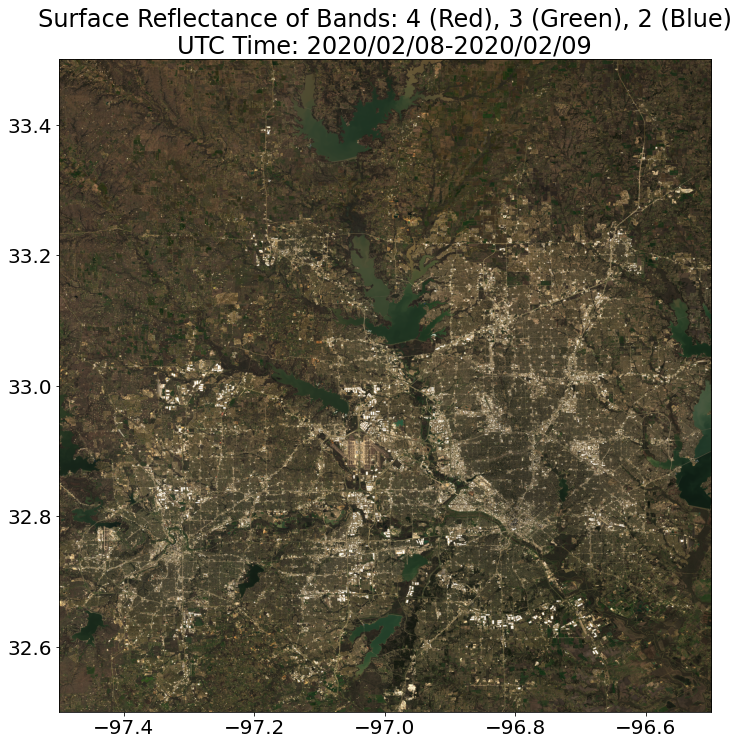

In [468]:
sd = '2020-02-08';
ed = '2020-02-09';
fn = 'Landsat8_SR_DFW_'+sd+'_'+ed;
filename = '../data/Landsat8/'+fn+'.tif'

# Open the file:
raster = gdal.Open(filename)

rasterArray = raster.ReadAsArray()*0.0001 # 0.0001 is the scale factor of the Landsat8 dataset
rasterArray = np.moveaxis(rasterArray, 0, -1) # move the channels to the last axis


gamma = 1.4
image = rasterArray[:,:,4:0:-1]

plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
plt.rcParams.update({'font.size': 20})

plt.imshow((image/0.3)**(1),  # For visualization, map value 0.3 to RGB64=1 (RGB8=255).
           extent = (-97.5,-96.5, 32.5, 33.5) #(left, right, bottom, top)
          )
plt.title("Surface Reflectance of Bands: 4 (Red), 3 (Green), 2 (Blue)\n"+
       "UTC Time: " + sd.replace('-','/') + '-' + ed.replace('-','/'))
plt.savefig("../figures/spatial/Landsat8/"+ fn+ ".png")

In [105]:
!gdalinfo ../data/Landsat8/Landsat8_SR_DFW_2020-01-07_2020-01-08.tif

Driver: GTiff/GeoTIFF
Files: ../data/Landsat8/Landsat8_SR_DFW_2020-01-07_2020-01-08.tif
Size is 3186, 3757
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 14N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 14N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-99,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1]

In [189]:
# coordinate transform:  x,y to lat,long
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(raster.GetProjectionRef())

wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""

new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 

width = raster.RasterXSize
height = raster.RasterYSize
gt = raster.GetGeoTransform()

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

x_left, x_right = minx + 30/2, maxx - 30/2
y_low , y_up    = miny + 30/2, maxy - 30/2
xs = np.linspace(x_left, x_right, width)
ys = np.linspace(y_low, y_up, height)

x, y = np.meshgrid(xs,ys)

#get the coordinates in lat long
# latlong = transform.TransformPoint(minx,miny) 
# latlong

In [745]:
index = np.random.choice(range(len(X)), 100000, replace = False)


In [780]:
# PCA
DR = 'PCA'
pca = PCA(n_components=4, random_state = 12)
X_pca = pca.fit_transform(X)


In [ ]:
# ICA
DR = 'ICA'
ica = FastICA(n_components=4, random_state = 12)
X_ica = ica.fit_transform(X)

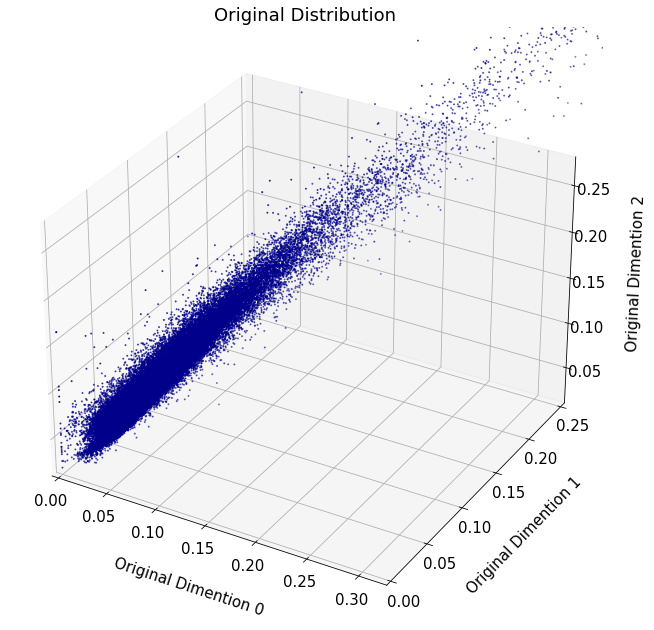

In [816]:
fig = plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size': 15})
ax = fig.add_subplot(projection='3d')

x_plot = X[index,0]
y_plot = X[index,1]
z_plot = X[index,2]
x_plot_min = max(x_plot.min(), x_plot.mean() - 5*x_plot.std())
x_plot_max = min(x_plot.max(), x_plot.mean() + 8*x_plot.std())
y_plot_min = max(y_plot.min(), y_plot.mean() - 5*y_plot.std())
y_plot_max = min(y_plot.max(), y_plot.mean() + 5*y_plot.std())
z_plot_min = max(z_plot.min(), z_plot.mean() - 5*y_plot.std())
z_plot_max = min(z_plot.max(), z_plot.mean() + 5*y_plot.std())

ax.scatter(x_plot, y_plot, z_plot, c = 'darkblue', s = 1)

ax.set_xlim(x_plot_min, x_plot_max)
ax.set_ylim(y_plot_min, y_plot_max)
ax.set_zlim(z_plot_min, z_plot_max)

ax.set_title('Original Distribution' )
ax.set_xlabel('Original' + " Dimention 0", labelpad=20)
ax.set_ylabel('Original' + " Dimention 1", labelpad=20)
ax.set_zlabel('Original' + " Dimention 2", labelpad=20)

plt.tight_layout()

dir_out = '../figures/spatial/Landsat8/'
if not os.path.exists(dir_out):
    os.mkdir(dir_out)
plt.savefig(dir_out + 'Landsat8_'+'Original' +'.png')

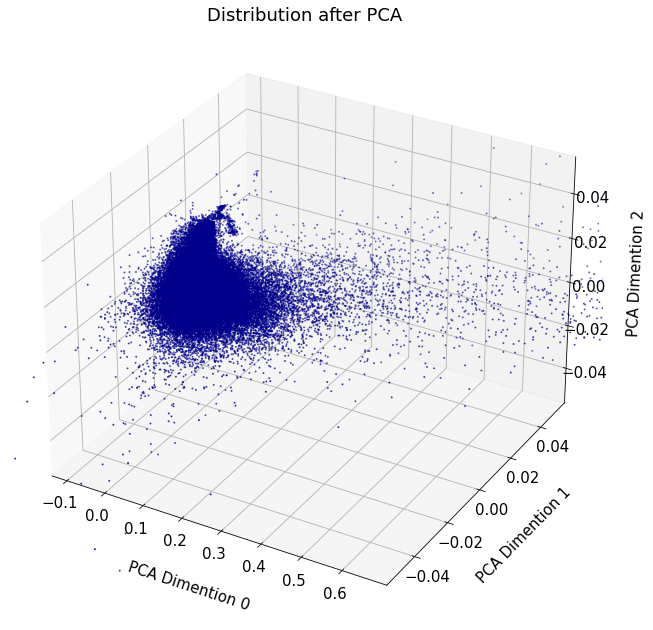

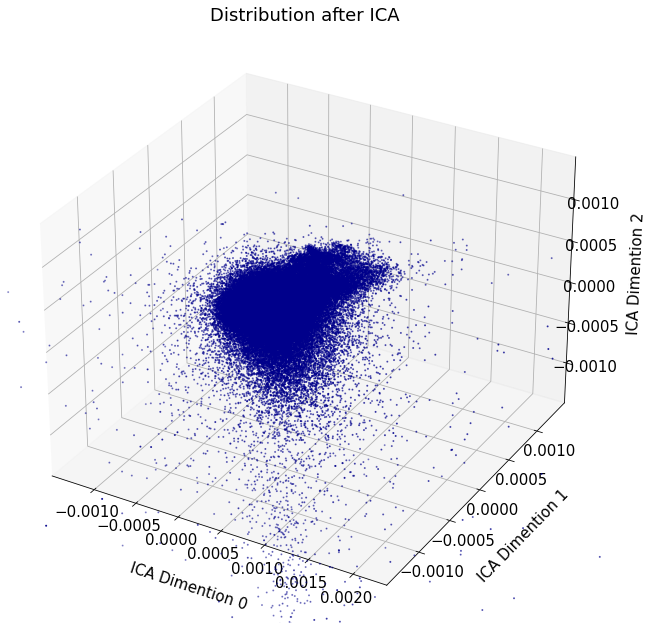

In [812]:
# scatter plot after dimension reduction: PCA, ICA
for DR, X_DR in [('PCA', X_pca), ('ICA', X_ica)]:
    x_plot = X_DR[index,0]
    y_plot = X_DR[index,1]
    z_plot = X_DR[index,2]

    plt.rcParams["figure.figsize"] = (8, 6) # (w, h)
    plt.rcParams.update({'font.size': 15})

    x_plot_min = max(x_plot.min(), x_plot.mean() - 5*x_plot.std())
    x_plot_max = min(x_plot.max(), x_plot.mean() + 8*x_plot.std())
    y_plot_min = max(y_plot.min(), y_plot.mean() - 5*y_plot.std())
    y_plot_max = min(y_plot.max(), y_plot.mean() + 5*y_plot.std())
    z_plot_min = max(z_plot.min(), z_plot.mean() - 5*y_plot.std())
    z_plot_max = min(z_plot.max(), z_plot.mean() + 5*y_plot.std())

    fig = plt.figure(figsize=(12,9))
    plt.rcParams.update({'font.size': 15})
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x_plot, y_plot, z_plot, c = 'darkblue', s = 1)

    ax.set_xlim(x_plot_min, x_plot_max)
    ax.set_ylim(y_plot_min, y_plot_max)
    ax.set_zlim(z_plot_min, z_plot_max)

    ax.set_title('Distribution after ' + DR )
    ax.set_xlabel(DR + " Dimention 0", labelpad=20)
    ax.set_ylabel(DR + " Dimention 1", labelpad=20)
    ax.set_zlabel(DR + " Dimention 2", labelpad=20)

    plt.tight_layout()

    dir_out = '../figures/spatial/Landsat8/' + DR + '/'
    if not os.path.exists(dir_out):
        os.mkdir(dir_out)
    plt.savefig(dir_out + 'Landsat8_'+DR +'.png')

In [818]:
index = np.random.choice(range(len(X)), 10000, replace = False)


In [837]:
# find best number of clusters for (PCA, ICA)x(K-Means, GM)
# KMeans Clusttering
for DR, X_DR in [('PCA', X_pca), ('ICA', X_ica)]:
    for model_name, model in [('K-Means', KMeans),('Gaussian Mixture', GaussianMixture)]:
        
        X_train = X_DR[index,:]
        n_clusters_list = []
        scores = []
        for i in range(1,10):
            model_i = model(i, random_state=0).fit(X_train)
            n_clusters_list.append(i)
            scores.append(model_i.score(X_train))

        plt.rcParams["figure.figsize"] = (8, 6) # (w, h)
        plt.rcParams.update({'font.size': 15})

        plt.plot(n_clusters_list, scores, c='k')
        plt.title(model_name + " Score vs Number of Clusters \n"+ str(len(index)) + " Samples")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Score")

        dir_out = '../figures/spatial/Landsat8/' + DR + '/' + model_name + '/'
        if not os.path.exists(dir_out):
            os.mkdir(dir_out)
        plt.savefig(dir_out + model_name + '_vs_n.png')
        plt.close()

In [800]:
n_clusters = 5 # K

# KMeans Clusttering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca)
# print(kmeans.labels_)
labels_kmeans = kmeans.labels_.reshape(image.shape[:2])

In [805]:
index = np.random.choice(range(len(X)), 100000, replace = False)

<Figure size 576x432 with 0 Axes>

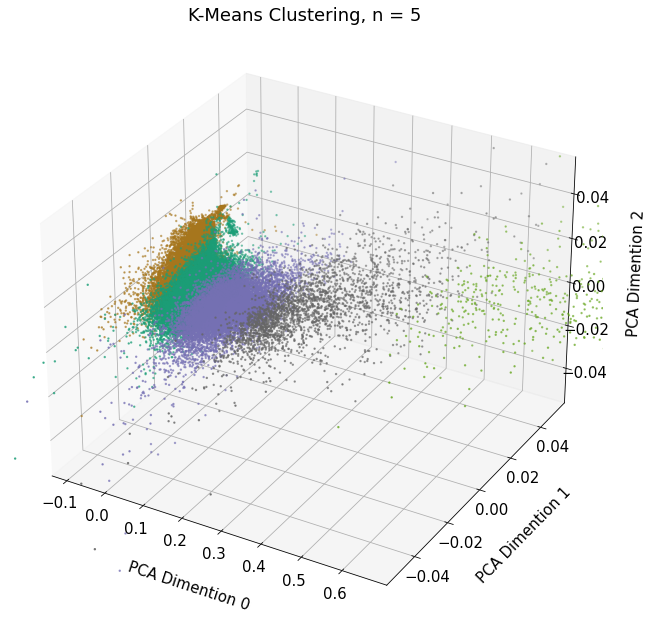

In [810]:
mpl.pyplot.set_cmap('Dark2')

x_plot = X_pca[index,0]
y_plot = X_pca[index,1]
z_plot = X_pca[index,2]
label_plot = labels_kmeans.flatten()[index]

x_plot_min = max(x_plot.min(), x_plot.mean() - 5*x_plot.std())
x_plot_max = min(x_plot.max(), x_plot.mean() + 8*x_plot.std())
y_plot_min = max(y_plot.min(), y_plot.mean() - 5*y_plot.std())
y_plot_max = min(y_plot.max(), y_plot.mean() + 5*y_plot.std())
z_plot_min = max(z_plot.min(), z_plot.mean() - 5*y_plot.std())
z_plot_max = min(z_plot.max(), z_plot.mean() + 5*y_plot.std())

fig = plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size': 15})
ax = fig.add_subplot(projection='3d')
ax.scatter(x_plot, y_plot, z_plot, c = label_plot, s = 2)

ax.set_xlim(x_plot_min, x_plot_max)
ax.set_ylim(y_plot_min, y_plot_max)
ax.set_zlim(z_plot_min, z_plot_max)

ax.set_title("K-Means Clustering, n = "+str(n_clusters))
ax.set_xlabel("PCA Dimention 0", labelpad=20)
ax.set_ylabel("PCA Dimention 1", labelpad=20)
ax.set_zlabel("PCA Dimention 2", labelpad=20)

plt.tight_layout()

dir_out = '../figures/spatial/Landsat8/kmeans/'
if not os.path.exists(dir_out):
    os.mkdir(dir_out)
plt.savefig(dir_out + 'kmeans_clustering_012.png')

In [613]:
# Gaussian Mixture Clusttering
gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(X_pca)
labels_gm = gm.predict(X_pca).reshape(image.shape[:2])

<Figure size 576x432 with 0 Axes>

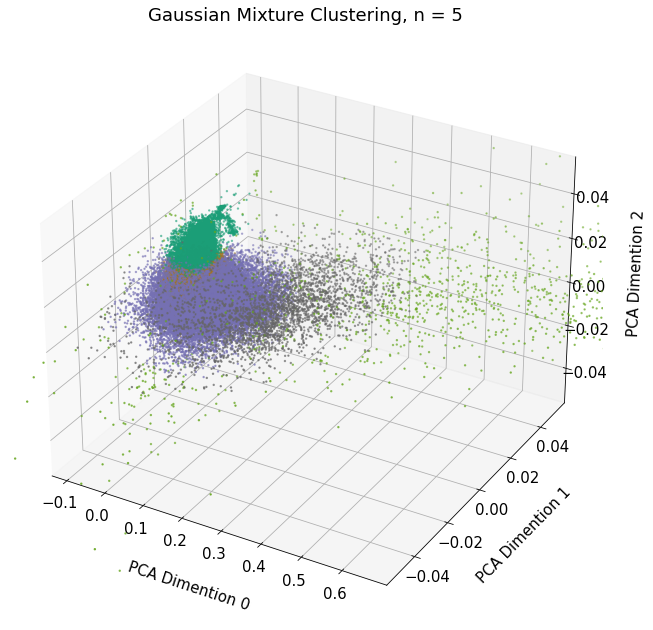

In [811]:
mpl.pyplot.set_cmap('Dark2')

x_plot = X_pca[index,0]
y_plot = X_pca[index,1]
z_plot = X_pca[index,2]
label_plot = labels_gm.flatten()[index]

x_plot_min = max(x_plot.min(), x_plot.mean() - 5*x_plot.std())
x_plot_max = min(x_plot.max(), x_plot.mean() + 8*x_plot.std())
y_plot_min = max(y_plot.min(), y_plot.mean() - 5*y_plot.std())
y_plot_max = min(y_plot.max(), y_plot.mean() + 5*y_plot.std())
z_plot_min = max(z_plot.min(), z_plot.mean() - 5*y_plot.std())
z_plot_max = min(z_plot.max(), z_plot.mean() + 5*y_plot.std())

fig = plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size': 15})
ax = fig.add_subplot(projection='3d')
ax.scatter(x_plot, y_plot, z_plot, c = label_plot, s = 2)

ax.set_xlim(x_plot_min, x_plot_max)
ax.set_ylim(y_plot_min, y_plot_max)
ax.set_zlim(z_plot_min, z_plot_max)

ax.set_title("Gaussian Mixture Clustering, n = "+str(n_clusters))
ax.set_xlabel("PCA Dimention 0", labelpad=20)
ax.set_ylabel("PCA Dimention 1", labelpad=20)
ax.set_zlabel("PCA Dimention 2", labelpad=20)

plt.tight_layout()

dir_out = '../figures/spatial/Landsat8/gm/'
if not os.path.exists(dir_out):
    os.mkdir(dir_out)
plt.savefig(dir_out + 'gm_clustering_012.png')

In [830]:
nth = {
    0: "0th",
    1: "1st",
    2: "2nd",
    3: "3rd",
    4: "4th"
    # etc
}

In [831]:
i

4

In [832]:
labels = labels_kmeans
model_name = "K-Means"

for i in range(n_clusters):
    image_i = image*(labels==i)[:,:, np.newaxis]
    plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
    plt.rcParams.update({'font.size': 20})

    plt.imshow(image_i/0.3,  # For visualization, map value 0.3 to RGB64=1 (RGB8=255).
               extent = (-97.5,-96.5, 32.5, 33.5) #(left, right, bottom, top)
              )
    plt.title("Surface Reflectance of Bands: 4 (Red), 3 (Green), 2 (Blue)\n"+
           "UTC Time: " + sd.replace('-','/') + '-' + ed.replace('-','/'))
    
    dir_out = '../figures/spatial/Landsat8/kmeans/'
    if not os.path.exists(dir_out):
        os.mkdir(dir_out)
    plt.savefig(dir_out+ fn + '_kmeans' + str(i) + ".png")
    plt.close()
    
    # whole map with highlight the label
    image_i = image.copy()
    color = [0.1,0.3,0.3]# image[labels==i].mean(axis = 0)
    image_i[labels==i] = color
    plt.imshow(image_i/0.3,  # For visualization, map value 0.3 to RGB64=1 (RGB8=255).
               extent = (-97.5,-96.5, 32.5, 33.5) #(left, right, bottom, top)
              )
    plt.title("Surface Reflectance: " + nth[i] +" Cluster of " + model_name +"\n"+
           "UTC Time: " + sd.replace('-','/') + '-' + ed.replace('-','/'))
    plt.savefig(dir_out+ fn + '_kmeans' + str(i) + "_highlight.png")
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [836]:
labels = labels_gm
model_name = "Gaussian Mixture"
for i in range(n_clusters):
    image_i = image*(labels==i)[:,:, np.newaxis]
    plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
    plt.rcParams.update({'font.size': 20})
    
    # pixels on that label
    plt.imshow(image_i/0.3,  # For visualization, map value 0.3 to RGB64=1 (RGB8=255).
               extent = (-97.5,-96.5, 32.5, 33.5) #(left, right, bottom, top)
              )
    plt.title("Surface Reflectance of Bands: 4 (Red), 3 (Green), 2 (Blue)\n"+
           "UTC Time: " + sd.replace('-','/') + '-' + ed.replace('-','/'))
    
    dir_out = '../figures/spatial/Landsat8/gm/'
    if not os.path.exists(dir_out):
        os.mkdir(dir_out)
    plt.savefig(dir_out+ fn + '_gm' + str(i) + ".png")
    plt.close()
    
    # whole map with highlight the label
    image_i = image.copy()
    color = [0.1,0.3,0.3]# image[labels==i].mean(axis = 0)
    image_i[labels==i] = color
    plt.imshow(image_i/0.3,  # For visualization, map value 0.3 to RGB64=1 (RGB8=255).
               extent = (-97.5,-96.5, 32.5, 33.5) #(left, right, bottom, top)
              )
    plt.title("Surface Reflectance: " + nth[i] +" Cluster of " + model_name +"\n"+
           "UTC Time: " + sd.replace('-','/') + '-' + ed.replace('-','/'))
    plt.savefig(dir_out+ fn + '_gm' + str(i) + "_highlight.png")
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [396]:
# save kmeans and gaussian mixture model
dir_model = '../models/spatial/Landsat8/'
if not os.path.exists(dir_out):
        os.mkdir(dir_out)
pickle.dump(kmeans, open( dir_model + "kmeans.p", "wb" ) )
pickle.dump(gm, open( dir_model + "gm.p", "wb" ) )

# save labels
pickle.dump(labels_kmeans, open( filename + "_labels_kmeans.p", "wb" ) )
pickle.dump(labels_gm, open( filename + "_labels_gm.p", "wb" ) )


In [804]:
# read saved model and labels 

# read saved model and labels 
kmeans = pickle.load( open( dir_model + "kmeans.p", "rb" ) )
gm_labels = pickle.load( open( filename + "_labels_kmeans.p", "rb" ) )

gm = pickle.load( open( dir_model + "gm.p", "rb" ) )
gm_labels = pickle.load( open( filename + "_labels_gm.p", "rb" ) )

In [ ]:
# design a function to transform from lat, long to cluster label

def latlong2label(lat, long):
    

In [ ]:
# append a label col to the driving dataset
